In [1]:
import warnings as wrn
wrn.filterwarnings('ignore')

import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

from sklearn.model_selection import StratifiedKFold

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

from zemberek import (
    TurkishSpellChecker,
    TurkishSentenceNormalizer,
    TurkishSentenceExtractor,
    TurkishMorphology,
    TurkishTokenizer
)

pd.set_option('display.max_columns', 500)

<b> 3 sınıfa ait olan verileri okuyalım ve bir dataframe'ye çevirelim ve etiketleyelim

In [2]:
# txt dosyasını oku
df = pd.DataFrame()
for i in range(1, 4):
    # veriler/{i} klasöründeki tüm dosya adlarını al
    file_names = os.listdir('veriler/raw_texts/{0}'.format(i))
    for file_name in file_names:
        # txt dosyasını cp1254 kodlamasıyla oku
        with open('veriler/raw_texts/{0}/{1}'.format(i, file_name), 'r', encoding='cp1254') as f:
            text = f.read()
            # dataframe'e metin ve sınıfı ekleyiyoruz
            df = df.append([[text, i]], ignore_index=True)

       
            
df.columns = ['text', 'class']

In [3]:
# lowercase
df['text'] = df['text'].apply(lambda x: str(x).lower())

# noktalama işaretlerini kaldır
df['text'] = df['text'].str.replace('[^\w\s]','')

# numerik değerleri kaldır
df['text'] = df['text'].str.replace('\d+', '')

#2991. satırda boş text var
df.drop(index=2991,axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [4]:
# zemberek nesneleri oluşturma
morphology = TurkishMorphology.create_with_defaults()
tokenizer = TurkishTokenizer.DEFAULT
normalizer = TurkishSentenceNormalizer(morphology)
spell_checker = TurkishSpellChecker(morphology)
sentence_extractor = TurkishSentenceExtractor()


2023-04-07 00:52:22,461 - zemberek.morphology.turkish_morphology - INFO
Msg: TurkishMorphology instance initialized in 3.7750630378723145



<b> datayı normalleştirelim yazım yanlışlarını düzeltelim

In [5]:
# normalize yazım yanlışlarını olabildiğince düzeltme işlemi
for i in range(df.shape[0]):
    try:
        df['text'][i] = normalizer.normalize(df['text'][i])
    except:
        print('error at index {0}'.format(i),"<>",df['text'][i])

<b>orjinal dataframe kaybetmemek için yeni bir dataframe'ye(df2) kopyalayım ve bu dataframe ile işlemelere devam edelim

In [6]:
df2 = df.copy()

In [7]:
# Kelime kökü bulma fonksiyonu
def lemmatize_text(text):
    lemmatized_text = []
    for sentence in text.split('.'):
        for word in sentence.split():
            if "turkcel" not in str(word).lower() and  "türkcel" not in str(word).lower() and "türksel" not in str(word).lower() and "turksel" not in str(word).lower():
                word_analysis = morphology.analyze_and_disambiguate(word).best_analysis()
                for analysis in list(word_analysis):
                    lemmatized_text.append(analysis.item.lemma)
    return lemmatized_text

In [8]:
# Kelime kökü bulma
df2['text'] = df2['text'].apply(lemmatize_text)

<b>stop word'lerin bulunduğu stop_words.txt'den data içinde bulunan stop word'leri çıkaralım

In [9]:
# stop words kaldırma from stop_words.txt
with open('stop_words.txt', 'r', encoding='utf-8') as f:
    stop_words = f.read().splitlines()

df2['text'] = df2['text'].apply(lambda x: [word for word in x if word not in stop_words])

<b>Frekanslarına göre görsel açıdan daha hoş bir görüntü için kelime bulutu görüntüsü oluşturalım

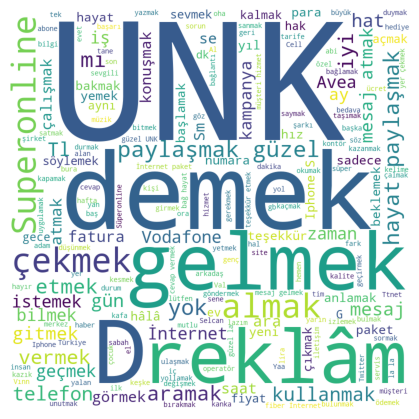

In [10]:
wordcloud = WordCloud(width=800, height=800,
                background_color='white',
                min_font_size=10).generate(' '.join(df2['text'].apply(lambda x: ' '.join(x))))

# plot the WordCloud image
plt.figure(figsize = (4, 4), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

<b> tf-idf matrisini oluşturalım

In [11]:
# tf-idf
tfidf = TfidfVectorizer()
tfidf.fit(df2['text'].apply(lambda x: ' '.join(x)))
tfidf_matrix = tfidf.transform(df2['text'].apply(lambda x: ' '.join(x)))

# tf-idf dataframe
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

In [12]:
tfidf_df.head()

,aa,aaa,aaah,aah,abartmak,abaza,abd,abdal,abe,abi,abla,abone,abur,acayip,access,acep,acil,acun,acur,acı,acımak,acımasız,acınmak,ad,adalet,adam,adana,adet,adi,adil,adliye,admin,adres,adsl,adıl,adım,ae,afedersin,aferin,affetmek,afiyet,afiş,afyon,ah,aha,ahmet,aile,ailecek,ait,ajans,ajda,ajitasyon,ak,aka,akademi,akar,akbank,akkavak,akmak,akmerkez,akordeon,akp,aksan,aksilik,aktarmak,aktivasyon,aktivite,akü,akıl,akım,akşam,al,alacak,alaka,alalamak,alan,alay,albüm,aldatmak,aldatı,aldırmak,alem,alet,algı,algılamak,ali,alican,alien,alihan,alive,alkol,alkış,all,allah,almak,almanya,alo,alperen,alsancak,alt,alternatif,altyapı,altın,alçak,alıkoymak,alım,alın,alınmak,alışkan,alışmak,alışveriş,am,aman,amaç,amblem,amca,amerika,amik,amin,amip,amma,an,ana,anadolu,anahtar,analiz,anas,anaç,and,android,androit,ani,ankamall,ankara,anket,anlam,anlamak,anlayış,anlaşma,anlaşmak,anmak,anne,anten,anı,apaçi,app,apple,application,aptal,ara,araba,araban,aracılığıyla,aralık,aram,aramak,arap,aras,arazi,araç,araştırmak,arda,ardi,ardından,are,arena,ark,arka,arkadaş,armut,arsa,art,artist,artmak,artı,arz,arzu,arıcak,arılar,arınç,arıza,arş,asansör,asar,asean,asker,aslan,asma,asmak,asıl,at,ata,atak,atakan,atamak,atar,atatürk,atay,ataşehir,ateş,atlamak,atmak,atv,atılmak,atılım,audi,av,avantaj,avea,avm,avrupa,avukat,axess,ay,ayak,ayakkabı,ayar,aybay,aycell,aydın,ayin,aylık,aynen,aynı,ayrı,ayrıcalık,ayrılık,ayrım,ayrıntı,aytaç,aytaş,ayten,ayvalık,ayı,ayık,ayıp,ayırmak,ayşe,ayşenur,azalmak,azim,aziz,azmi,azıcık,açmak,açı,açık,açıklama,açıklamak,açıl,...,zaman,zannetmek,zara,zarar,zaytung,zehra,zekeriya,zeki,zekâ,zengin,zevk,zihniyet,ziraat,zirve,ziyan,ziyaret,zmir,zmit,zor,zorlamak,zıkkım,zımbırtı,zırt,zıvır,âdet,âdeta,âşık,çaba,çabalamak,çabuk,çakal,çakar,çakma,çakmak,çaktırmadan,çalmak,çalıntı,çalışmak,çamur,çanakkale,çap,çapak,çare,çarpmak,çarşamba,çarşı,çat,çatır,çay,çağatay,çağla,çağlayan,çağrı,çağrışmak,çağrışım,çağırmak,çek,çekecek,çekememek,çekiliş,çekim,çekirge,çekmek,çello,çenet,çerçeve,çevirmek,çevre,çevrim,çift,çikolata,çile,çim,çin,çip,çiy,çizme,çiçek,çocuk,çocukluk,çoluk,çook,çoook,çorlu,çoğalmak,çutur,çökmek,çöl,çöp,çöpdemir,çöpçatan,çöpçü,çözmek,çözüm,çüş,çıkar,çıkarmak,çıkartmak,çıkmak,çıkmaz,çıldırmak,çılgın,ödemek,ödül,öf,öiv,öksürmek,öldürmek,ölmek,ölçü,ölüm,ömür,öncelik,öncü,önem,öner,öneri,önermek,önlem,öpmek,örnek,ötmek,övmek,öylesine,öz,özcan,özde,özel,özellik,özellikle,özen,özenmek,özenti,özetlemek,özge,özgün,özgür,özlemek,özlüce,özman,özmen,öztürk,özür,özürlü,öç,öğle,öğlen,öğrenci,öğrenmek,öğretmek,öğretmen,ücret,ülen,ülgen,ülke,ülker,ümit,üni,ünite,üniversite,üniversitesi,ünv,üremek,ürün,üst,üste,üstelik,üvey,üye,üzer,üzeri,üzgün,üzmek,üçüncü,üşenmek,ırz,ısmarlamak,ısrar,ıssız,ısı,ısınmak,ısırmak,ıvır,ızgara,ışık,ışımak,şaat,şahan,şahane,şahenk,şahin,şahsen,şahsiyet,şaka,şamata,şampiyon,şan,şans,şapka,şarj,şark,şarkı,şart,şaypa,şaşkınbakkal,şaşmak,şaşmaz,şaşırmak,şbir,şe,şebeke,şeffaf,şehir,şeker,şekil,şelli,şemsiye,şen,şener,şenlik,şerbet,şeref,şerit,şeytan,şiddet,şifre,şiir,şikayet,şikayetvar,şike,şikâyet,şimdiden,şimdilik,şimşek,şip,şirin,şirket,şişe,şişirmek,şoför,şok,şov,şua,şubat,şube,şâti,şükür,şüphe,şık,şımarmak
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

<b>Görüldüğü üzere 3421 adet kelime mevcut

<b>Bu kısımda feature selection işlemi ANOVA ile birlikte 10-fold stratified cross validation işlemi gerçekleştirildi.
<b>Öncelikle 1 ile 3421 en iyi feauture sayısı denenerek ardından cross validation işlemi yapıldı.Örneğin en iyi 10 feature seçildi ve bu 10 adet feature ile 10-fold stratified cv yapıldı ve f1-macro sonucu bir listede tutuldu.bunun gibi tüm en iyi feature kombinasyonları denenerek en iyi 10-fold cv sonucu elde edilen k adet best feature için optimum k(best feature number) elde edildi.

In [16]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
best_n = []
f1_macro = []
# alpha=0.1 seçmemdeki amaç modelin sınıf ayrımlarını daha iyi görebilmesi için.
# ilerleyen aşamalarda farklı alpha değerleri ile denenebilir.
model = MultinomialNB(fit_prior=True, alpha=0.1)
skor_df_bayes = pd.DataFrame(columns=['best_n', 'f1-macro'])

for i in range(1,tfidf_df.shape[1]):
    f1 = []
    
    select_best = SelectKBest(f_classif, k=i)
    select_best.fit(tfidf_df, df2['class'])
    tfidf_df_best = select_best.transform(tfidf_df)
    tfidf_df_best = pd.DataFrame(tfidf_df_best.tolist())

    for train_index, test_index in skf.split(tfidf_df_best, df2['class']):
        X_train, X_test = tfidf_df_best.iloc[train_index], tfidf_df_best.iloc[test_index]
        y_train, y_test = df2.iloc[train_index,1], df2.iloc[test_index,1]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        f1.append(f1_score(y_test, y_pred, average='macro'))

    f1_macro.append(np.mean(f1))
    best_n.append(i)
    skor_df_bayes = skor_df_bayes.append({'best_n': i, 'f1-macro': np.mean(f1)}, ignore_index=True)


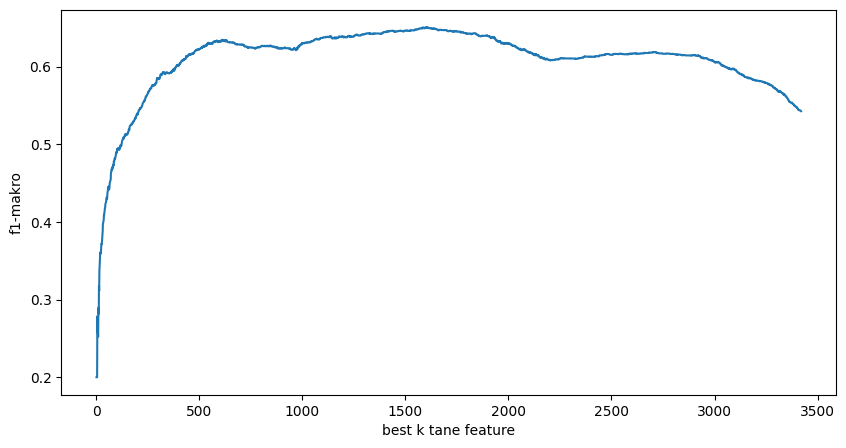

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(best_n, f1_macro)
plt.xlabel('best k tane feature')
plt.ylabel('f1-makro')
plt.show()

In [18]:
# best f1
skor_df_bayes[skor_df_bayes['f1-macro'] == skor_df_bayes['f1-macro'].max()]

,best_n,f1-macro
1606,1607.0,0.650647


<b>En yüksek 10-fold stratified cv (f1-macro) ANOVA sonucuna göre en iyi feature sayısı 1607 olarak belirlendi

In [24]:
# 1607 best features seçimi
select_best = SelectKBest(f_classif, k=1607)
select_best.fit(tfidf_df, df2['class'])
tfidf_df_new = select_best.transform(tfidf_df)

tfidf_df_new = pd.DataFrame(tfidf_df_new.tolist(), columns=tfidf_df.columns[select_best.get_support()])

In [25]:
# best feature names
best_features = tfidf_df_new.columns.tolist()

In [26]:
X = tfidf_df_new
y = df2['class']

In [27]:
# 10 fold stratified cross validation

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

nb = MultinomialNB(alpha=0.1, fit_prior=True)

precision_class1 = []
precision_class2 = []
precision_class3 = []

recall_class1 = []
recall_class2 = []
recall_class3 = []

f1_class1 = []
f1_class2 = []
f1_class3 = []

tp_class1 = []
tp_class2 = []
tp_class3 = []

tn_class1 = []
tn_class2 = []
tn_class3 = []

fp_class1 = []
fp_class2 = []
fp_class3 = []

fn_class1 = []
fn_class2 = []
fn_class3 = []

support_class1 = []
support_class2 = []
support_class3 = []

acc = []

validation_df = pd.DataFrame(columns=['Sınıf 1 (olumlu)','Sınıf 2 (olumsuz)',
                                      'Sınıf 3 (nötr)','MACRO AVARAGE',
                                      'MICRO AVARAGE (weighted avarage)'],
                                      index=['Precision','Recall','F-Score','True Positive adedi','False Positive adedi','False Negative adedi'])

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # reset index
    X_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)

    
    nb.fit(X_train, y_train)
    y_pred = nb.predict(X_test)

    # 1. sınıf için TP, TN, FP, FN değerleri
    tp1 = sum([1 for i in range(len(y_test)) if y_test[i] == 1 and y_pred[i] == 1])
    tn1 = sum([1 for i in range(len(y_test)) if y_test[i] != 1 and y_pred[i] != 1])
    fp1 = sum([1 for i in range(len(y_test)) if y_test[i] != 1 and y_pred[i] == 1])
    fn1 = sum([1 for i in range(len(y_test)) if y_test[i] == 1 and y_pred[i] != 1])

    # 2. sınıf için TP, TN, FP, FN değerleri
    tp2 = sum([1 for i in range(len(y_test)) if y_test[i] == 2 and y_pred[i] == 2])
    tn2 = sum([1 for i in range(len(y_test)) if y_test[i] != 2 and y_pred[i] != 2])
    fp2 = sum([1 for i in range(len(y_test)) if y_test[i] != 2 and y_pred[i] == 2])
    fn2 = sum([1 for i in range(len(y_test)) if y_test[i] == 2 and y_pred[i] != 2])

    # 3. sınıf için TP, TN, FP, FN değerleri
    tp3 = sum([1 for i in range(len(y_test)) if y_test[i] == 3 and y_pred[i] == 3])
    tn3 = sum([1 for i in range(len(y_test)) if y_test[i] != 3 and y_pred[i] != 3])
    fp3 = sum([1 for i in range(len(y_test)) if y_test[i] != 3 and y_pred[i] == 3])
    fn3 = sum([1 for i in range(len(y_test)) if y_test[i] == 3 and y_pred[i] != 3])

    

    # Her class için precision, recall, f1-score değerleri

    precision_class1.append(precision_score(y_test, y_pred, average=None)[0])
    precision_class2.append(precision_score(y_test, y_pred, average=None)[1])
    precision_class3.append(precision_score(y_test, y_pred, average=None)[2])

    recall_class1.append(recall_score(y_test, y_pred, average=None)[0])
    recall_class2.append(recall_score(y_test, y_pred, average=None)[1])
    recall_class3.append(recall_score(y_test, y_pred, average=None)[2])

    f1_class1.append(f1_score(y_test, y_pred, average=None)[0])
    f1_class2.append(f1_score(y_test, y_pred, average=None)[1])
    f1_class3.append(f1_score(y_test, y_pred, average=None)[2])

    # tp, tn, fp, fn değerleri

    tp_class1.append(tp1)
    tp_class2.append(tp2)
    tp_class3.append(tp3)

    tn_class1.append(tn1)
    tn_class2.append(tn2)
    tn_class3.append(tn3)

    fp_class1.append(fp1)
    fp_class2.append(fp2)
    fp_class3.append(fp3)

    fn_class1.append(fn1)
    fn_class2.append(fn2)
    fn_class3.append(fn3)  

    # her tahmin edilen class için support değerleri
    support1 = sum([1 for i in range(len(y_test)) if y_pred[i] == 1])
    support2 = sum([1 for i in range(len(y_test)) if y_pred[i] == 2])
    support3 = sum([1 for i in range(len(y_test)) if y_pred[i] == 3])
    
    support_class1.append(support1)
    support_class2.append(support2)
    support_class3.append(support3)
    
    # accuracy
    acc.append(accuracy_score(y_test, y_pred))


# sınıf 1 için
validation_df['Sınıf 1 (olumlu)']['Precision'] = np.mean(precision_class1)
validation_df['Sınıf 1 (olumlu)']['Recall'] = np.mean(recall_class1)
validation_df['Sınıf 1 (olumlu)']['F-Score'] = np.mean(f1_class1)
validation_df['Sınıf 1 (olumlu)']['True Positive adedi'] = np.sum(tp_class1)
validation_df['Sınıf 1 (olumlu)']['True Negative adedi'] = np.sum(tn_class1)
validation_df['Sınıf 1 (olumlu)']['False Positive adedi'] = np.sum(fp_class1)
validation_df['Sınıf 1 (olumlu)']['False Negative adedi'] = np.sum(fn_class1)

# sınıf 2 için
validation_df['Sınıf 2 (olumsuz)']['Precision'] = np.mean(precision_class2)
validation_df['Sınıf 2 (olumsuz)']['Recall'] = np.mean(recall_class2)
validation_df['Sınıf 2 (olumsuz)']['F-Score'] = np.mean(f1_class2)
validation_df['Sınıf 2 (olumsuz)']['True Positive adedi'] = np.sum(tp_class2)
validation_df['Sınıf 2 (olumsuz)']['True Negative adedi'] = np.sum(tn_class2)
validation_df['Sınıf 2 (olumsuz)']['False Positive adedi'] = np.sum(fp_class2)
validation_df['Sınıf 2 (olumsuz)']['False Negative adedi'] = np.sum(fn_class2)

# sınıf 3 için
validation_df['Sınıf 3 (nötr)']['Precision'] = np.mean(precision_class3)
validation_df['Sınıf 3 (nötr)']['Recall'] = np.mean(recall_class3)
validation_df['Sınıf 3 (nötr)']['F-Score'] = np.mean(f1_class3)
validation_df['Sınıf 3 (nötr)']['True Positive adedi'] = np.sum(tp_class3)
validation_df['Sınıf 3 (nötr)']['True Negative adedi'] = np.sum(tn_class3)
validation_df['Sınıf 3 (nötr)']['False Positive adedi'] = np.sum(fp_class3)
validation_df['Sınıf 3 (nötr)']['False Negative adedi'] = np.sum(fn_class3)

# macro avarage
validation_df['MACRO AVARAGE']['Precision'] = (np.mean(precision_class1) + np.mean(precision_class2) + np.mean(precision_class3)) / 3

validation_df['MACRO AVARAGE']['Recall'] = (np.mean(recall_class1) + np.mean(recall_class2) + np.mean(recall_class3)) / 3

validation_df['MACRO AVARAGE']['F-Score'] = (np.mean(f1_class1) + np.mean(f1_class2) + np.mean(f1_class3)) / 3

# micro weighted avarage

validation_df['MICRO AVARAGE (weighted avarage)']['Precision'] = (np.mean(precision_class1) * np.sum(support_class1) + np.mean(precision_class2) * np.sum(support_class2) + np.mean(precision_class3) * np.sum(support_class3)) / (np.sum(support_class1) + np.sum(support_class2) + np.sum(support_class3))

validation_df['MICRO AVARAGE (weighted avarage)']['Recall'] = (np.mean(recall_class1) * np.sum(support_class1) + np.mean(recall_class2) * np.sum(support_class2) + np.mean(recall_class3) * np.sum(support_class3)) / (np.sum(support_class1) + np.sum(support_class2) + np.sum(support_class3))

validation_df['MICRO AVARAGE (weighted avarage)']['F-Score'] = (np.mean(f1_class1) * np.sum(support_class1) + np.mean(f1_class2) * np.sum(support_class2) + np.mean(f1_class3) * np.sum(support_class3)) / (np.sum(support_class1) + np.sum(support_class2) + np.sum(support_class3))


# accuracy

print('Accuracy 10 fold stratified cross validation : ', np.mean(acc))

Accuracy 10 fold stratified cross validation :  0.680566332218506


In [28]:
validation_df 

,Sınıf 1 (olumlu),Sınıf 2 (olumsuz),Sınıf 3 (nötr),MACRO AVARAGE,MICRO AVARAGE (weighted avarage)
Precision,0.734906,0.656754,0.70647,0.699377,0.68189
Recall,0.493351,0.90519,0.526261,0.641601,0.744928
F-Score,0.588704,0.761057,0.602181,0.650647,0.693918
True Positive adedi,373,1165,503,NaN,NaN
False Positive adedi,138,610,210,NaN,NaN
False Negative adedi,383,122,453,NaN,NaN
